# VLE of glassy polymers

This is an example for a VLE calculation featuring a polymer and a solvent. PC-SAFT calculation for a water sorption isotherm of the polymer PVP were performed (the dotted line in Figure 2 of https://doi.org/10.3390/membranes12040434). 

In [1]:
import numpy as np
from epcsaftpy import component, pcsaft, NETGP
from sgtpy.equilibrium import bubblePy   # sgtpy module
import matplotlib.pyplot as plt

The the first part of the code is basically the same as presented in VLE_Water_Sorption_Polymer_part1.ipynb

In [2]:
Water = component('Water', ms = 1.2046817736, sigma = [2.7927, 10.11, -0.01775, -1.417, -0.01146], eps = 353.9449,
                 kappaAB = 0.045090, eAB = 2425.6714, sites = [0, 1, 1], Mw = 18.01528)
PVP = component('PVP', ms = 1045.99, sigma = 2.71 , eps = 205.599, 
               kappaAB = 0.02, eAB = 0., sites = [0, 231, 231], Mw = 25700.)
mix = Water + PVP
mix.set_kijsaft(i = 0, j = 1, kij0 = -0.128)
saft = pcsaft(mix, compute_critical = False)
saft_Water = saft.pure_eos[0]

# NET-GP implementation
netsaft = NETGP(saft)

In [3]:
T = 298.15
p0w, _, _ = saft_Water.psat(T)
yi = np.asarray([1, 0])

wi = np.asarray([0.2,0.8])
Mw = saft.Mw
xi_fun = lambda wi, Mw : wi / Mw / (wi / Mw).sum()

netsaft.ksw = 0.4279 / p0w**2
netsaft.rho0p = 1000*1506.704837 / saft.Mw[1]
netsaft.NET = True

In [6]:
def Isotherm(eos, n = 100, wl = 1e-4, wu = 1):
        w1vec = np.linspace(wl, wu, n)
        wvec = np.stack((w1vec, 1 - w1vec))
        v0 = [None, None]
        Xass0 = [None, None]
        pivec = []
        pi = p0w*0.5
        for i in range(n):
                eos.yi = yi
                wi = wvec[:, i]
                xi = xi_fun(wi, Mw)
                res = bubblePy(yi, pi, xi, T, eos, v0 = v0, Xass0 = Xass0, full_output=True)
                pi = res.P
                vL = [res.v1, res.v2]
                XassL = [res.Xassl, res.Xassv]
                pivec.append(pi)
        pivec = np.asarray(pivec)
        RHvec = pivec/p0w
        return w1vec, RHvec

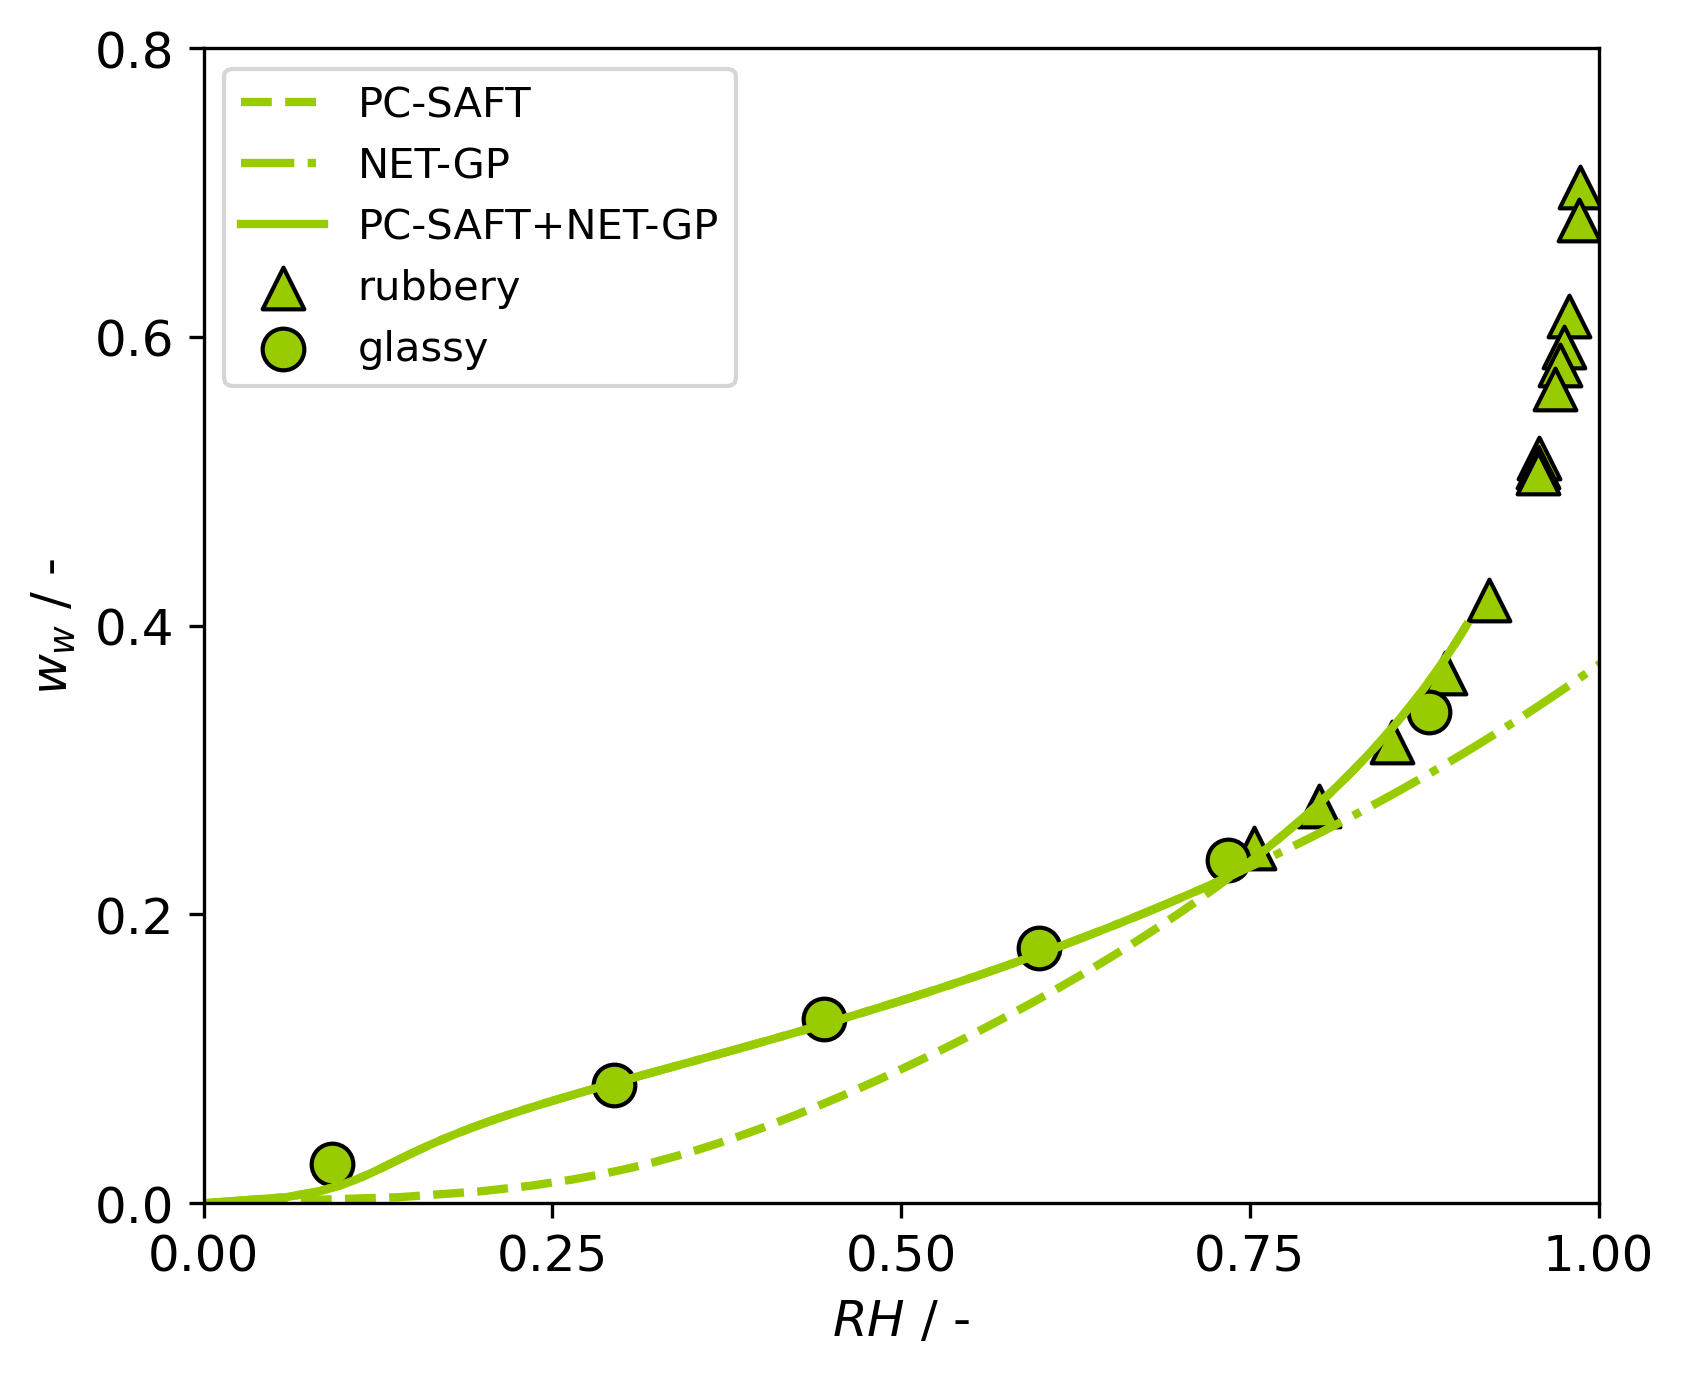

In [7]:
wl = 1e-4
wu = 0.4
w1vec,RHvec = Isotherm(saft, n = 100, wl = wl,wu = wu)
w1vecnet,RHvecnet = Isotherm(netsaft, n = 100,wl = wl, wu = wu)

font = {'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

colorVLE = "#99CC00"

fig, ax = plt.subplots(figsize = (6, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

RHexp = [0.9868,0.9858,0.9787,0.9749,0.9724,0.9685,0.9576,0.9565,0.9563,0.9217,0.89,0.8519,0.7998,0.7529]
wexp = [0.704,0.6808,0.6142,0.593,0.5808,0.5638,0.5162,0.5096,0.506,0.4175,0.3672,0.3193,0.275,0.246]

RHexp2 = [0.0924,0.2939,0.4449,0.599,0.7344,0.8781]
wexp2 = [0.0274269,0.0821512,0.1275743,0.1764984,0.237775,0.3401576]



ax.plot(RHvec,w1vec, "--",color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(RHvecnet,w1vecnet, "-.",color = colorVLE , 
        linewidth = 2.0, label = "NET-GP")
ax.plot(RHvec[RHvec<RHvecnet],w1vec[RHvec<RHvecnet], "-",color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT+NET-GP")
ax.plot(RHvecnet[RHvec>RHvecnet],w1vecnet[RHvec>RHvecnet], "-",color = colorVLE , 
        linewidth = 2.0)


ax.scatter(RHexp, wexp, s = 100, c = colorVLE, marker="^", 
            linewidth=1.0, edgecolor='k', label = "rubbery")
ax.scatter(RHexp2, wexp2, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "glassy")



ax.legend(fontsize="small")
ax.set_ylabel('$w_w$ / -')
ax.set_xlabel('$RH$ / -')
ax.axis([0, 1., 0, 0.8])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))
plt.show()